# Fake News

## Import

In [1]:
import re
import time

import nltk
import pandas as pd
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')  # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
df = pd.read_csv('../american_datasets/cleaned/1.csv', index_col=0)
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text label  
0  WASHINGTON (Reuters) - The head of a conservat...  True  
1  WASHINGTON (Reuters) - Transgender people will...  True  
2  WASHINGTON (Reuters) - The special counsel inv...  True  
3  WASHINGTON (Reuters) - Trump campaign adviser ...  True  
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  True

In [3]:
df.shape

(44898, 3)

## Visualization

(array([21417.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 23481.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

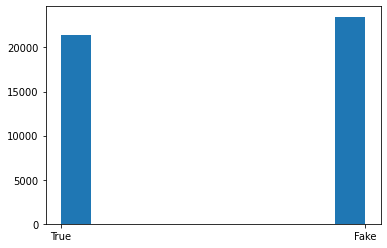

In [4]:
plt.hist(df['label'])

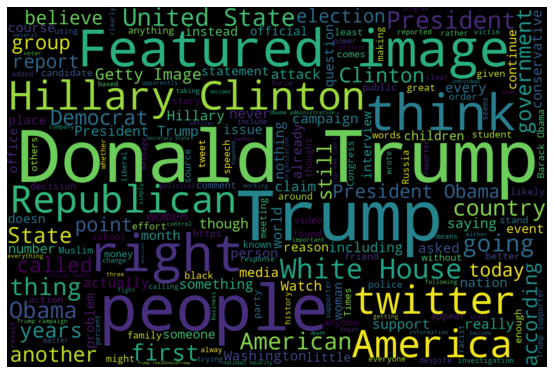

In [5]:
all_text = " ".join([str(txt) for txt in df[df['label'] == 'Fake']['text']])

wordcloud = WordCloud(min_word_length=5, width=1500, height=1000, background_color='black').generate(all_text)

fig = plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing

### Remove junk

In [6]:
def clean(text):
    text = str(text)
    #all lowercase
    text = text.lower()

    # remove escape sequences
    text = re.sub(r'(\r\n|\n|\r|\t)', ' ', text)

    # remove urls
    text = re.sub(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ',
        text)

    # remove html
    text = re.sub(r'<.*?>', ' ', text)

    # remove emoj
    text = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", text, flags=re.UNICODE)

    # remove all not alphanumeric character
    text = re.sub("[^a-z]+", " ", text)
    return text


df['title'] = [clean(title) for title in df['title']]
df['text'] = [clean(text) for text in df['text']]
df.head()

title  \
0  as u s budget fight looms republicans flip the...   
1  u s military to accept transgender recruits on...   
2  senior u s republican senator let mr mueller d...   
3  fbi russia probe helped by australian diplomat...   
4  trump wants postal service to charge much more...   

                                                text label  
0  washington reuters the head of a conservative ...  True  
1  washington reuters transgender people will be ...  True  
2  washington reuters the special counsel investi...  True  
3  washington reuters trump campaign adviser geor...  True  
4  seattle washington reuters president donald tr...  True

### Remove stop words

In [7]:
stop_words = set(stopwords.words("english"))


def remove_stop_words(text):
    res = []
    for word in text.split():
        if word not in stop_words:
            res.append(word)
    return " ".join(res)


df['title'] = [remove_stop_words(title) for title in df['title']]
df['text'] = [remove_stop_words(text) for text in df['text']]
df.head()

title  \
0  u budget fight looms republicans flip fiscal s...   
1  u military accept transgender recruits monday ...   
2     senior u republican senator let mr mueller job   
3  fbi russia probe helped australian diplomat ti...   
4  trump wants postal service charge much amazon ...   

                                                text label  
0  washington reuters head conservative republica...  True  
1  washington reuters transgender people allowed ...  True  
2  washington reuters special counsel investigati...  True  
3  washington reuters trump campaign adviser geor...  True  
4  seattle washington reuters president donald tr...  True

### Stemming

In [8]:
snowball_stemmer = SnowballStemmer(language='english')


def stemmer(text):
    res = []
    for word in text.split():
        res.append(snowball_stemmer.stem(word))
    return " ".join(res)


df['title'] = [stemmer(title) for title in df['title']]
df['text'] = [stemmer(text) for text in df['text']]
df.head()

title  \
0  u budget fight loom republican flip fiscal script   
1  u militari accept transgend recruit monday pen...   
2       senior u republican senat let mr mueller job   
3  fbi russia probe help australian diplomat tip nyt   
4  trump want postal servic charg much amazon shi...   

                                                text label  
0  washington reuter head conserv republican fact...  True  
1  washington reuter transgend peopl allow first ...  True  
2  washington reuter special counsel investig lin...  True  
3  washington reuter trump campaign advis georg p...  True  
4  seattl washington reuter presid donald trump c...  True

## ML Model

In [9]:
def print_metrics(y_test, y_pred, training_time):
    print('0. Training time:', round(training_time), 's')
    print('1. Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('2. Precision:', round(precision_score(y_test, y_pred, average='macro'), 4))
    print('3. Recall:', round(recall_score(y_test, y_pred, average='macro'), 4))
    print('4. F1 score:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('5. Confusion Matrix\n\n', pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

In [10]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# pre processing
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
countVectorizer = CountVectorizer(min_df=2, max_df=0.7, ngram_range=(1, 2), tokenizer=token.tokenize)
tfidfTransformer = TfidfTransformer()

classifiers = [
    RandomForestClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(n_jobs=8)
]

#fit and prediction
for classifier in classifiers:
    start_time = time.time()
    
    print('---------------------------------')
    print(str(classifier))
    pipe = Pipeline(
        [
            ('vect', countVectorizer),
            ('tfidf', tfidfTransformer),
            ('classifier', classifier)
        ]
    )

    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    training_time = time.time() - start_time 
    print_metrics(y_test, y_pred, training_time)

---------------------------------
RandomForestClassifier(n_jobs=8)


0. Training time: 31 s
1. Accuracy: 0.9846
2. Precision: 0.9844
3. Recall: 0.9848
4. F1 score: 0.9846
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       6928   136
True         71  6335
---------------------------------
LogisticRegression(n_jobs=8)


0. Training time: 18 s
1. Accuracy: 0.984
2. Precision: 0.9839
3. Recall: 0.9842
4. F1 score: 0.984
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       6931   133
True         82  6324
---------------------------------
DecisionTreeClassifier()


0. Training time: 43 s
1. Accuracy: 0.9969
2. Precision: 0.9969
3. Recall: 0.9969
4. F1 score: 0.9969
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       7041    23
True         19  6387
---------------------------------
AdaBoostClassifier()


0. Training time: 68 s
1. Accuracy: 0.9967
2. Precision: 0.9966
3. Recall: 0.9967
4. F1 score: 0.9967
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       7035    29
True         16  6390
---------------------------------
KNeighborsClassifier(n_jobs=8)


0. Training time: 25 s
1. Accuracy: 0.5347
2. Precision: 0.7649
3. Recall: 0.5108
4. F1 score: 0.3674
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       7064     0
True       6268   138
